 # Skin Diasese detection test

In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [20]:
tf.__version__

'2.10.0'

## Processing the training set

In [21]:
# train_datagen = ImageDataGenerator(
#     rescale=1./255,
#     zoom_range=0.1,
#     horizontal_flip=True,
#     brightness_range=[0.9,1.1],
#     fill_mode='nearest'
# )
# training_set = train_datagen.flow_from_directory(
#     'C:/Users/User/Downloads/6_skin_diseases/kaggle/train',
#     target_size=(128, 128),
#     batch_size=16,
#     class_mode='categorical',
# )

## Preprocessing the test set

In [22]:
# test_datagen = ImageDataGenerator(rescale=1./255)
# test_set = test_datagen.flow_from_directory(
#     'C:/Users/User/Downloads/6_skin_diseases/kaggle/test',
#     target_size=(128, 128),
#     batch_size=16,
#     class_mode='categorical',
# )

In [ ]:

# Common parameters
BATCH_SIZE   = 32
IMG_SIZE     = (320, 320)
DATA_DIR     = r"C:\Users\User\Downloads\Skin-disease-dataset\train"
SEED         = 42           # keeps split reproducible
VAL_SPLIT    = 0.20         # 80 % train, 20 % validation

datagen = ImageDataGenerator(
    rescale=1./255,
    zoom_range=0.1,
    horizontal_flip=True,
    brightness_range=[0.9, 1.1],
    fill_mode='nearest',
    validation_split=VAL_SPLIT      # ← **key line**
)



training_set = datagen.flow_from_directory(
    DATA_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',              # ← **80 % of images**
    shuffle=True,
    seed=SEED
)

test_set = datagen.flow_from_directory(
    DATA_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',            # ← **20 % of images**
    shuffle=True,
    seed=SEED
)


Found 38751 images belonging to 6 classes.
Found 9683 images belonging to 6 classes.


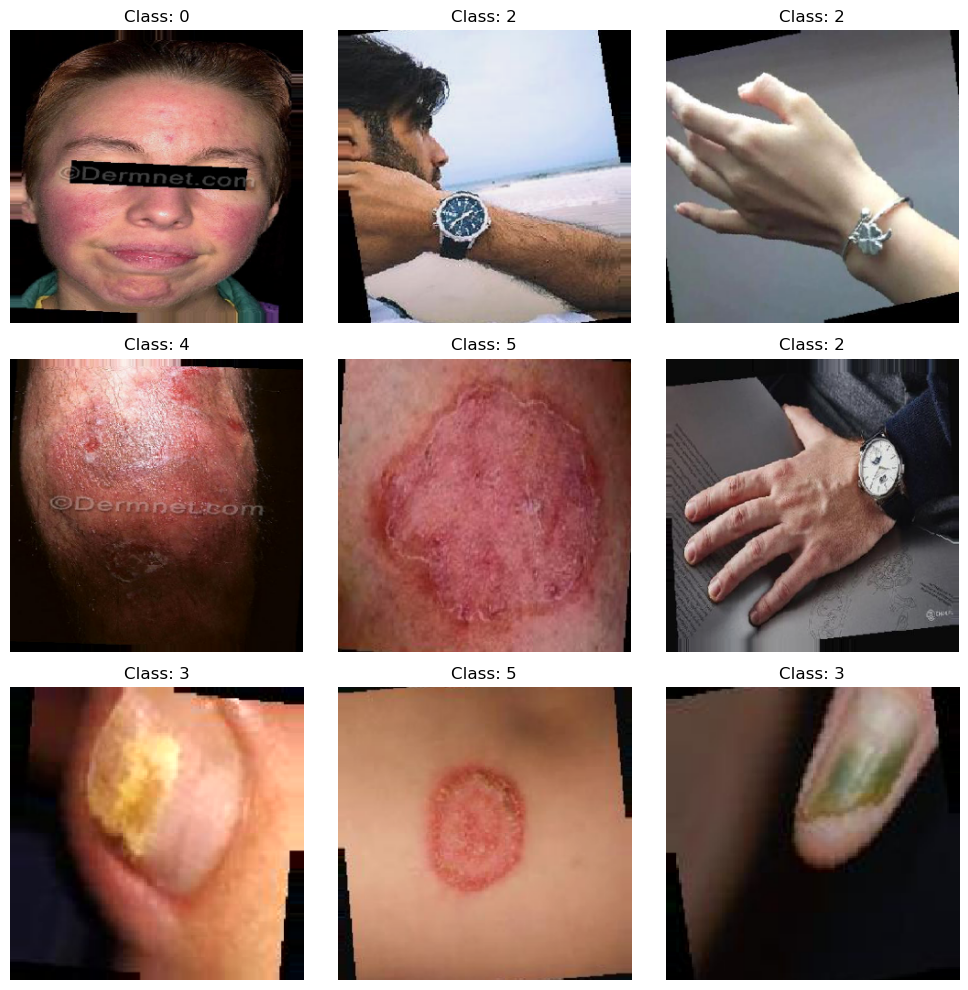

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# Get one batch from the training set
images, labels = next(training_set)

# Show 9 augmented images
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.title(f"Class: {np.argmax(labels[i])}")
    plt.axis("off")
plt.tight_layout()
plt.show()


## Building the CNN

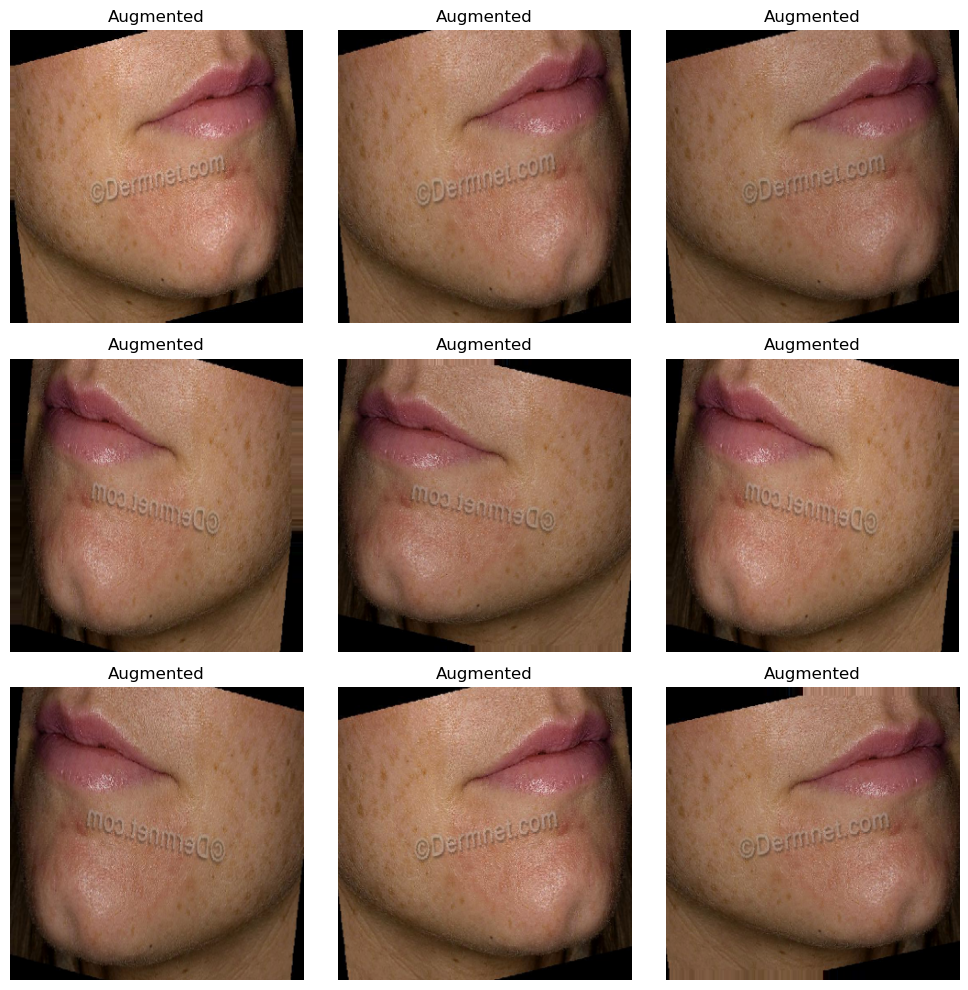

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing import image

# Load a single image path
img_path = training_set.filepaths[0]
img = image.load_img(img_path, target_size=IMG_SIZE)
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)

# Show multiple augmented versions
plt.figure(figsize=(10, 10))
for i in range(9):
    augmented = datagen.flow(x, batch_size=1)
    aug_img = next(augmented)[0]  # single image in batch
    plt.subplot(3, 3, i + 1)
    plt.imshow(aug_img)
    plt.title("Augmented")
    plt.axis("off")
plt.tight_layout()
plt.show()


In [26]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint


# Load Pretrained MobileNetV2 (Exclude top layers)
base_model = MobileNetV2(input_shape=(320, 320, 3),
                         include_top=False,
                         weights='imagenet')
base_model.trainable = True
for layer in base_model.layers[:-40]: 
    layer.trainable = False



# Add Custom Classification Head
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    BatchNormalization(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(5, activation='softmax')
])




# Train Model
callbacks = [
    EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7),
    ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True)
]

# Stage 1: Train only classifier head
base_model.trainable = False
model.compile(optimizer=Adam(1e-3), loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(training_set, validation_data=test_set, epochs=10)

# Stage 2: Fine-tune entire model
base_model.trainable = True
model.compile(optimizer=Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(training_set, validation_data=test_set, epochs=20)


Epoch 1/10
1087/1087 [==============================] - 1287s 1s/step - loss: 0.8153 - accuracy: 0.6692 - val_loss: 0.9207 - val_accuracy: 0.6722
Epoch 2/10
1087/1087 [==============================] - 1231s 1s/step - loss: 0.6226 - accuracy: 0.7505 - val_loss: 1.1097 - val_accuracy: 0.7007
Epoch 3/10
1087/1087 [==============================] - 1250s 1s/step - loss: 0.5476 - accuracy: 0.7831 - val_loss: 0.9210 - val_accuracy: 0.7194
Epoch 4/10
1087/1087 [==============================] - 1267s 1s/step - loss: 0.4821 - accuracy: 0.8116 - val_loss: 0.8617 - val_accuracy: 0.7404
Epoch 5/10
1087/1087 [==============================] - 1425s 1s/step - loss: 0.4388 - accuracy: 0.8302 - val_loss: 0.8918 - val_accuracy: 0.7544
Epoch 6/10
1087/1087 [==============================] - 1505s 1s/step - loss: 0.4001 - accuracy: 0.8492 - val_loss: 0.9760 - val_accuracy: 0.7598
Epoch 7/10
1087/1087 [==============================] - 1533s 1s/step - loss: 0.3605 - accuracy: 0.8639 - val_loss: 0.9361 -

1/1 [==============================] - 1s 773ms/step


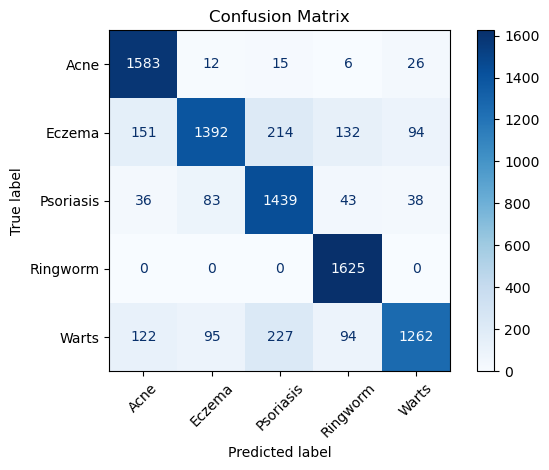

In [27]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# 1. Get true labels and predictions
Y_true = []
Y_pred = []

# Go through test batches and collect predictions
for i in range(len(test_set)):
    x_batch, y_batch = test_set[i]
    y_pred_batch = model.predict(x_batch)
    
    Y_true.extend(np.argmax(y_batch, axis=1))
    Y_pred.extend(np.argmax(y_pred_batch, axis=1))

    if (i + 1) * test_set.batch_size >= test_set.samples:
        break  # Stop if we've processed all test data

# 2. Compute confusion matrix
cm = confusion_matrix(Y_true, Y_pred)
labels = list(test_set.class_indices.keys())  # Class names

# 3. Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()


In [ ]:
# eval_datagen = ImageDataGenerator(rescale=1./255)

# eval_set = eval_datagen.flow_from_directory(
#     'C:/Users/User/Downloads/6_skin_diseases/kaggle/val',
#     target_size=(128, 128),
#     batch_size=64,
#     class_mode='categorical',
#     shuffle=False  # Important: keep order for correct confusion matrix
# )
# import numpy as np
# from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# import matplotlib.pyplot as plt

# # Predict
# y_true = eval_set.classes
# y_pred_probs = model.predict(eval_set)
# y_pred = np.argmax(y_pred_probs, axis=1)

# # Class names
# class_labels = list(eval_set.class_indices.keys())

# # Confusion matrix
# cm = confusion_matrix(y_true, y_pred)
# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
# disp.plot(cmap='Blues', xticks_rotation=45)
# plt.title("Confusion Matrix on Custom Eval Folder")
# plt.tight_layout()
# plt.show()


In [28]:
model.save('299-model-test-v3.h5')

In [32]:
import numpy as np
from tensorflow.keras.utils import load_img, img_to_array  # ✅ Modern import

# Load and preprocess the image
test_image = load_img('C:/Users/User/Downloads/Skin-disease-dataset/single-prediction/Eczema3.jpg', target_size=(128, 128))
test_image = img_to_array(test_image)
test_image = np.expand_dims(test_image, axis=0)

# Predict using the CNN model
result = model.predict(test_image)

# Define class labels in the same order as training_set.class_indices
class_labels = [
    "Acne",
    "Eczama",
    "Psoriasis",
    "Rigworm",
    "Warts"
]

# Get the predicted class index
predicted_index = np.argmax(result[0])
prediction = class_labels[predicted_index]

print("Predicted class:", prediction)

1/1 [==============================] - 0s 24ms/step
Predicted class: Warts
